In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import spacy.cli

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
spacy.cli.download('en')
nlp = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
df = pd.read_csv('/content/data.csv')

In [4]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [7]:
# separando apenas 40% dos dados
df_40 = df.sample(frac=0.4, random_state=1)
df_40

,Sentence,Sentiment
3218,The loss for the third quarter of 2007 was EUR...,positive
689,The winner does not have to be present to win .,neutral
5811,$BOBE down $2.84 premarket,negative
2985,$MTD (Mettler-Toledo) ready for a breakout,positive
2914,Finnish M-real 's Kyro mill is starting negoti...,neutral
...,...,...
89,"In September 2010 , the Finnish group agreed t...",positive
1635,UPDATE 1-EU regulator backs approval for GSK i...,positive
1992,"Profit before taxes amounted to EUR 56.5 mn , ...",neutral
2639,Also Chile is an important market area for for...,neutral


In [8]:
df_40['Sentiment'].value_counts()

neutral     1228
positive     769
negative     340
Name: Sentiment, dtype: int64

In [9]:
# Verificando o pré-processamento que será usado para preparar o conjuto de dados e definir o pipeline.

texto = df_40.Sentence[3218]

print('--------------')
print('Texto original')
print(texto)

doc = nlp(texto)
tokens_filtrado = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]

print('--------------')
print('Remoção de stopwords e pontuação')
print(tokens_filtrado)

lemmas = [token.lemma_.lower().strip() for token in tokens_filtrado]

print('--------------')
print('Lemmatization')
print(lemmas)

--------------
Texto original
The loss for the third quarter of 2007 was EUR 0.3 mn smaller than the loss of the second quarter of 2007 .
--------------
Remoção de stopwords e pontuação
[loss, quarter, 2007, EUR, 0.3, mn, smaller, loss, second, quarter, 2007]
--------------
Lemmatization
['loss', 'quarter', '2007', 'eur', '0.3', 'mn', 'small', 'loss', 'second', 'quarter', '2007']


In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
# Criando classe para gerenciar X e y
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Função para removre espacos em branco no inicio e
# no fim do texto e converter todo o texto em letras
# minusculas
def clean_text(texto):     
    return texto.strip().lower()

# Função para remover todas as stopwords e pontuações
def tokenizer(texto):
    doc = nlp(texto)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens

# Criando um objeto CountVectorizer para vetorizar cada texto
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1)) 

# modelo de Regressão Logistica
classifier = LogisticRegression()


In [12]:
# Separando em X e y
X = df_40.Sentence
y = df_40.Sentiment

# Separando em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Construindo uma pipeline
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)


In [13]:
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred, average='macro'):.2f}")
print(f"Sensitividade: {recall_score(y_test, y_pred, average='macro'):.2f}")

Acurácia: 0.72
Precisão: 0.65
Sensitividade: 0.60


In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.48      0.25      0.33        63
     neutral       0.74      0.85      0.79       261
    positive       0.73      0.69      0.71       144

    accuracy                           0.72       468
   macro avg       0.65      0.60      0.61       468
weighted avg       0.70      0.72      0.70       468



Usando o modelo para classificar os seguintes textos extraídos do site Financial Times.

In [15]:
tabela = {
    'Texto': ['Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety',
              'China opens up bond market in bid to woo foreign investors',
              'HM Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this',
              'Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism',
              'Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate'],
          
    'Esperado': ['negativo','neutro','negativo','negativo','neutro']
}

ft_df = pd.DataFrame(tabela)
ft_df

,Texto,Esperado
0,"Central banks’ rate rises, geopolitical risk a...",negativo
1,China opens up bond market in bid to woo forei...,neutro
2,HM Revenue & Customs says residents had £850bn...,negativo
3,Japan’s horrifying crop of data falsification ...,negativo
4,"Despite internal problems, the group continues...",neutro


In [16]:
ft_df['Obtido'] = pipe.predict(ft_df.Texto)
ft_df

,Texto,Esperado,Obtido
0,"Central banks’ rate rises, geopolitical risk a...",negativo,positive
1,China opens up bond market in bid to woo forei...,neutro,neutral
2,HM Revenue & Customs says residents had £850bn...,negativo,positive
3,Japan’s horrifying crop of data falsification ...,negativo,neutral
4,"Despite internal problems, the group continues...",neutro,neutral


#### Análise exploratória para identifique as três empresas mais citadas e quantificar os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas.

Extraindo entidades

In [17]:
# usando todo o dataset para a analise exploratoria
X_2 = df.Sentence
y_2 = df.Sentiment

In [18]:
# criando um dataframe com as entidades
entidades = []

for i, frase in enumerate(X_2):
  for ent in nlp(frase.lower()).ents:
    entidades.append([ent.text, ent.label_, y_2.loc[i]])

entidades = pd.DataFrame(entidades, columns=['entidade', 'label', 'sentimento'])

In [19]:
num_entidades = entidades['label'].value_counts().sum()
print(f'Existem {num_entidades} entidades no texto.')

Existem 14037 entidades no texto.


Número de empresas

In [20]:
org = entidades[entidades['label'] == 'ORG']
print('Total de empresas:')
org['label'].value_counts()


Total de empresas:


ORG    2418
Name: label, dtype: int64

As três empresas mais citadas

In [21]:
print('Essas são as 3 empresas mais citadas:')
org['entidade'].value_counts().sort_values(ascending=False).head(3)

Essas são as 3 empresas mais citadas:


oyj      67
eur      57
nokia    53
Name: entidade, dtype: int64

In [23]:
# criando tabela com as 3 empresas mais citadas
empresas = entidades.query('label == "ORG" and entidade in ["oyj", "eur", "nokia"]')

pd.crosstab(empresas.entidade, empresas.sentimento)

sentimento,negative,neutral,positive
entidade,,,
eur,9,26,22
nokia,3,34,16
oyj,14,34,19


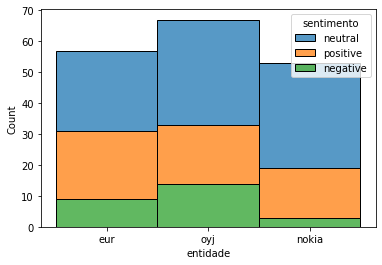

In [24]:
sns.histplot(x='entidade',hue='sentimento', data=empresas, multiple="stack")

Observando o grafico com as 3 empresas mais citadas, o sentimento neutro se destacou como o sentimento mais comum.

In [25]:
# separando as entidades para analise individual nos graficos
eur = empresas[empresas['entidade'] == 'eur']
nokia = empresas[empresas['entidade'] == 'nokia']
oyj = empresas[empresas['entidade'] == 'oyj']

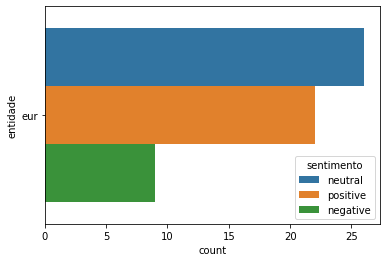

In [26]:
sns.countplot(y="entidade", hue='sentimento', data=eur)

In [27]:
print(f"Total: {eur['sentimento'].value_counts().sum()}")
print(eur['sentimento'].value_counts())

Total: 57
neutral     26
positive    22
negative     9
Name: sentimento, dtype: int64


A empresa **eur** possui 57 citações no total. A empresa possui mais que o dobro de citações positivas em relação as citações negativas. Mas, é evidente que as citações neutras ainda são a maioria.

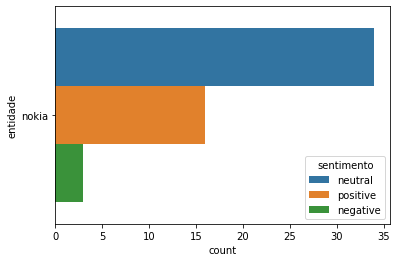

In [28]:
sns.countplot(y="entidade", hue='sentimento', data=nokia)

In [29]:
print(f"Total: {nokia['sentimento'].value_counts().sum()}")
print(nokia['sentimento'].value_counts())

Total: 53
neutral     34
positive    16
negative     3
Name: sentimento, dtype: int64


A empresa **nokia** possui 53 citações no total. A empresa possui mais que o quintuplo de citações positivas em relação as citações negativas, e é a empresa com menos citações negativas entre as 3 mais citadas. Mas, é evidente que as citações neutras ainda são a maioria, chegando a ser duas vezes mais citadas que outros sentimentos.

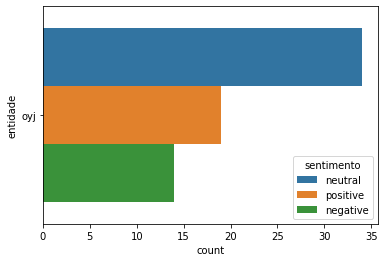

In [30]:
sns.countplot(y="entidade", hue='sentimento', data=oyj)

In [31]:
print(f"Total: {oyj['sentimento'].value_counts().sum()}")
print(oyj['sentimento'].value_counts())

Total: 67
neutral     34
positive    19
negative    14
Name: sentimento, dtype: int64


A empresa **oyj** possui 67 citações no total, sendo a entidade mais citada. A empresa també possui o maior numero de citações negativas (14), mas as citações positivas ainda se destacam das citações negativas. É evidente que as citações neutras ainda são a maioria.